# Text Analysis With Python 

## Introduction - Lorin

To follow along...

Packages that need to be installed

pandas
sklearn


## Python Packages often used for Text Analysis - Rolando
- Directly related to Text Analysis
    - NLTK
    - spaCy
    - Textblob
    - Gensim
    - Transformers

- Useful tools for text analysis
    - Pandas
    - Scikit-Learn
    - Matplotlib


## Mini-project 1: Word Frequencies (1:05) - Rolando

#### Data: [Jane Eyre - Charlotte Brontë](https://www.gutenberg.org/files/1260/1260-h/1260-h.htm)
#### Tools: NLTK, Scitkit-learn, Pandas
#### Method: Simple N-grams (Document vs Chapters), Maybe TF-IDF, 

##### 1. Load in text

We're going to use `urlretrieve` to save a local copy of the Jane Eyre text file.

In [ ]:
from urllib.request import urlretrieve

urlretrieve('https://www.gutenberg.org/cache/epub/1260/pg1260.txt', 'jane_eyre.txt')

doc = open('jane_eyre.txt', 'r').readlines()


We can see that the text file is read line by line, so we're going to have to split the list into sections.

In [ ]:
doc[:20]

We're going to focus on the text from the preface and chapters from the book. First, we're obtaining the indexes of of where these section titles appear in the list of lines from the text.

In [ ]:
chapter_idx = []

for idx, line in enumerate(doc):
    if 'CHAPTER' in line:
        chapter_idx.append((idx, line.strip()))
        
print(chapter_idx)

Now, we're going to push a list of lines that pertain to the certain section into a new list.

In [ ]:
chapter_texts = []

for idx, ch in enumerate(chapter_idx):
    # Skipping the first line of the section to cut out the chapter title
    start_line = ch[0]+1
    
    # Setting the end line of the chapter based on when the following chapter starts
    try:
        end_line = chapter_idx[idx+1][0]
    except:
        end_line = len(doc)
        
    # Adds text to the list of chapter texts
    chapter_texts.append(doc[start_line:end_line])    

In [ ]:
# the first ten lines from the preface
chapter_texts[0][:10]

##### 2. Processing/Cleaning the text

We have the text we want, but now we have to process the text we're working with. This involves removing line breaks (`\n`) and punctuation. In other cases, this might involve stemming or lemmatizing words. 

In [ ]:
import re

# join the lines together first with nested list comprehensions while removing items that are only line breaks
joined_chs = [''.join([line for line in ch if line != '\n']) for ch in chapter_texts]

print(joined_chs)

In [ ]:
# replace remaining break lines with spaces
no_bl_chs = [re.sub(r'\n', ' ', ch) for ch in joined_chs]

print(no_bl_chs)

Since we're going going to be using sentences are our documenet length instead of chapters, we need to remove the periods after "Mr" and "Mrs" to prevent sentences being split at the wrong place (i.e. `"Mr. Rochester goes..."` => `["Mr", "Rochester goes..."]`)

In [ ]:
# remove punctuation except periods
no_punct_chs = [re.sub(r'[:;,_“”\']', '', ch) for ch in no_bl_chs]

# remove periods after Mr and Mrs
no_punct_chs=[re.sub(r'(?<=Mr)\.', '', ch) for ch in no_punct_chs]
no_punct_chs=[re.sub(r'(?<=Mrs)\.', '', ch) for ch in no_punct_chs]

print(no_punct_chs)

Now, we will tokenize the chapters into sentence-level tokens and reduce our list into a one-dimensional list.

In [ ]:
# divide chapters into sentences
from nltk.tokenize import PunktSentenceTokenizer
from functools import reduce
# nltk.download('punkt)

punkt = PunktSentenceTokenizer()

# this operation produces a list of lists of sentences (i.e. [["sentence 1", "sentence 2"], ["sentence 3", "sentence 4"]])
sents = [punkt.tokenize(ch) for ch in no_punct_chs]

# reduce the two-dimensional list into a one-dimensional list
sent_tokens = reduce(lambda x,y :x+y ,sents)

#### 3. Vectorize Text
Using Scikit-learn's [Count Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and [TFIDF Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

Scikit-learn has a built-in tool `CountVectorizer` which allows us to pass in a corpus of text and it will return vectors informing us how many times a word showed up in a document (sentence) for ebery word that appears in the corpus. 

We didn't remove stop words earlier in the preprocessing step because `CountVectorizer` allows us to indicate stop words when initializing it. By default, it sets all words to lowercase, but we have set the parameter here to make it explicit. Additionally, we can set what ngrams we're interested in (unigrams, bigrams, trigrams, etc).

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

stopwords = list(stopwords.words('english'))

# demonstrating some of the parameters within Count Vectorizer
vc = CountVectorizer(lowercase=True, 
                     stop_words=stopwords,
                     ngram_range=(2,2),
                    
                     min_df=0.001)

vectors = vc.fit_transform(sent_tokens)


In [ ]:
print(vc.vocabulary_)

We can create a dataframe of vectors. The columns refer to the bigrams extracted from the corpus. Each row's index refers to a document (sentence) in the corpus. The values in each cell is how many times that bigram appeared in the sentence. 

In [ ]:
cols = vc.get_feature_names_out()
word_vect_df = pd.DataFrame(data=vectors.toarray(), columns=cols)
word_vect_df.sample(10)

We can see the top 20 bigrams with the higestest frequencies

In [ ]:
word_vect_df.sum(axis=0).sort_values(ascending=False).head(20)

In [ ]:
import matplotlib.pyplot as plt

word_counts = word_vect_df.sum(axis=0).sort_values(ascending=False)
plt.barh(y=word_counts.index[:10], width=word_counts[:10])
plt.show()

Many of the words with the highest frequencies are part of characters' names, which we expect to show up a lot more. These don't necessarily give us a lot of information however, but we can check how 'informative' these terms are by finding their TFIDF scores. 

In [ ]:
tc = TfidfVectorizer(lowercase=True, 
                     stop_words=stopwords,
                     ngram_range=(2,2),
                     max_df=0.9,
                     min_df=0.1)

tc_vectors = tc.fit_transform(no_punct_chs)


tfidf_vect_df = pd.DataFrame(data=tc_vectors.toarray(), columns=tc.get_feature_names_out())
tfidf_vect_df.sample(10)

In [ ]:
tfidf_vect_df.mean(axis=0).sort_values(ascending=False).head(20)

#### Term Co-Occurance

We may be interested in see how words co-occur with others words. In this case, we will use unigrams instead of bigrams. 

In [ ]:
cvc = CountVectorizer(lowercase=True, 
                     stop_words=stopwords,
                     ngram_range=(1,1),
                    
                     min_df=0.001)

co_vectors = cvc.fit_transform(sent_tokens)

# matrix manipulation 
co_matrix = (co_vectors.T * co_vectors)
# setting the diagonals to 0 since it will always be 1 when we're comparing the same words
co_matrix.setdiag(0)

Below is a dataframe that shows how many times one word (column) co-occurs within the same sentence as another word (row)

In [ ]:
co_cols = cvc.get_feature_names_out()
co_df = pd.DataFrame(data=co_matrix.toarray(), columns=co_cols, index=co_cols)
co_df.sample(10)

We may be interested in seeing what are the most common words that show up in the same sentence that 'rochester' (referring to Mr. Rochester) appears. 

In [ ]:
co_df['rochester'].sort_values(ascending=False).head(20)

## Mini-project 2: Classification (1:15) - Lorin

#### Data: [On the Books Laws](https://cdr.lib.unc.edu/concern/data_sets/v405sk89q?locale=en)
#### Tools: Scitkit-learn, Pandas, 
#### Methods: Supervised (Jim Crow vs. Non-Jim Crow) vs Unsupervised (Topic-modeling)
#### Helpful: [Comparing classifiers](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)


### Create Testing & Training Sets

Bring in labeled training set

In [ ]:
import pandas as pd

df = pd.read_csv("datasets/otb_training_set.csv")
df.info()

Includes 512 examples of Jim Crow laws and 1273 non Jim Crow laws.

In [ ]:
df.jim_crow.value_counts()

Laws were labeled as Jim Crow or Not Jim Crow according to scholarly works (Pauli Murray, Richard Paschal) and experts at UNC (William Sturkey, among others)

In [ ]:
df.source.value_counts()

We need to pick a target for our classification, aka the "output".

In [ ]:
target = df["jim_crow"]

What features do we want to train the models on? They will be our "inputs".

In [ ]:
features = df.loc[:, "section_text" : "type_session laws"]
features.info()

Use train-test-split to separate data into training and testing sets. 80% will be training, 20% will be testing - set by test_size = 0.2.  Data is chosen for the different sets at random, so random_state allows us all to get the same results. X_train and X_test include the inputs. y_train and y_test include the output.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 25)

### Vectorize the text

As above, we need to find word frequencies

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(decode_error = "ignore", min_df = 2, max_df = 1000)

In this case, we've chosen to ingore errors when it comes to characters with the wrong encoding. Additionally, we are not including any words that are too rarely used in the text (less than two times) or too often used (more than 1000 times).

Below, the vectorization is applied.

In [ ]:
X_train = vec.fit_transform(X_train.section_text)
X_test = vec.transform(X_test.section_text)

Now we need to decide on a machine learning classification model. In this case, we are using multinomial Naive Bayes which comes with sklearn.

In [ ]:
from sklearn.naive_bayes import MultinomialNB


nb = MultinomialNB()
nb.fit(X_train, y_train)



Now that we've trained the model on our data, let's use it on the testing set and see how well it did.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

preds = nb.predict(X_test)
print(classification_report(y_test, preds))

In [ ]:
import seaborn as sns

# count the number of labels
labels = np.unique(preds)

data = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

# use sns.heatmap on top of confusion_matrix to show the confusion matrix
ax = sns.heatmap(df_cm,xticklabels=True, annot=True, fmt='.0f')

We remove stopwords, tokenize the text, lemmatize

## Mini-project 3: Sentiment Analysis (1:35) - Rolando

#### Data: [Chaptgpt Sentiment Analysis](https://www.kaggle.com/datasets/charunisa/chatgpt-sentiment-analysis)
#### Tools: Textblob, NLTK
#### Methods: Dictionary (+ rule-based)

We will be using a [dataset of tweets about ChatGPT from Kaggle](https://www.kaggle.com/datasets/charunisa/chatgpt-sentiment-analysis/data?select=file.csv) for this example. 

#### 1. Importing ChatGPT twitter data

In [118]:
df = pd.read_csv('./datasets/chatgpt_sentiment.csv', encoding='utf-8')


In [ ]:
df.shape

In [119]:
df.sample(10)

,Unnamed: 0,tweets,labels
125282,125282,So @FortniteGame &amp; @EpicGames i asked Chat...,neutral
94924,94924,Look how they massacred my boyyyy 😭 #ChatGPT #...,bad
85915,85915,#ChatGPT is much more useful than Google in a...,neutral
134112,134112,Explained: What is ChatGPT?\n https://t.co/tTB...,bad
205915,205915,Looks like an informative piece on //limitatio...,good
102639,102639,New bot ChatGPT will force colleges to get cre...,bad
49414,49414,What is OpenAI's chatbot ChatGPT and what is i...,bad
67149,67149,First try 💁#ChatGPT https://t.co/3QcUCFF2PU,bad
114689,114689,ChatGPT AI making devs worried😭😂\nWriting code...,bad
218250,218250,I’ve been playing around with #AI for a little...,good


In [120]:
df_sample = df.copy().sample(50000)

#### 1. Simple Sentiment Analysis using Textblob

[`TextBlob`](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis) is a Python library that allows for easy access to text analysis methods such as parts-of-speech tagging, tokenization, term frequencies, sentiment analysis, and more. 

In [121]:
#! pip install textblob
from textblob import TextBlob

# simple example of TextBlob
example_tweet = TextBlob(df.tweets[22747])

example_tweet.sentiment_assessments

Sentiment(polarity=0.3, subjectivity=0.7, assessments=[(['greatest'], 1.0, 1.0, None), (['game'], -0.4, 0.4, None)])

`TextBlob.sentiment_assessments` returns the overall sentiment polarity and subjectivity of the sentence alongside the polarity and subjectivity of individual terms that make up the composite score. Polarity scores range from -1 (most negative) to 1 (most positive); subjectivity scores range from 0 (most objective) to 1 (most subjective). Below we can see the text that of the tweet that had a polarity score of 0.3 and a subjectivity score of 0.7.

In [122]:
df.tweets[22747]

'ChatGPT is the greatest video game of all time'

In [123]:
# method to return the sentiment scores for a given text
def textblob_scores(text):
    try:
        return TextBlob(text).sentiment
    except:
        dict() # returns an empty dictionary if there is an issue with the text

In [124]:
# find the sentiment polarity/subjectivity scores for all the tweets in our sample dataframe
tweets_txtblob = df_sample.tweets.apply(textblob_scores).apply(pd.Series)

# creates new columns in with those scores 
tweet_scores = pd.concat([df_sample, tweets_txtblob], axis =1)

In [125]:
# renames columns so we can make sense of them 
tweet_scores.rename(columns={0: 'textblob_polarity', 1: 'textblob_subjectivity'}, inplace=True)

tweet_scores.sample(5)

,Unnamed: 0,tweets,labels,textblob_polarity,textblob_subjectivity
44013,44013,After trying #ChatGPT and seeing how insane it...,bad,-0.070000,0.575000
44415,44415,AI - ChatGPT \n\nSay hello to your new guru ht...,bad,0.136364,0.454545
39339,39339,she is asking me to slow down 😐\n\n#ChatGPT #O...,bad,-0.227778,0.344444
126100,126100,Remember you have to get the ChatGPT: Chat wit...,bad,0.000000,0.000000
213451,213451,#SearchEngine : How The ChatGPT Watermark Work...,bad,0.000000,0.000000


#### 2. Sentiment Analysis using NLTK

[`NLTK`](https://www.nltk.org/) has has a  `SentimentintensityAnalyzer` module for sentiment analysis which uses the [`Vader model`](https://ojs.aaai.org/index.php/ICWSM/article/view/14550). Vader uses both a sentiment valence lexicon alongside rule-based modifiers to determine sentiment scores. `Valence` refers to the direction and intensity of a score ("worst" vs "bad" vs "best"). `Lexicon` refers to list of words that are mapped to a particular sentiment or emotion score. 

Unlike the sentiment scores from `TextBlob`, the scores for individual words in `Vader` range from -4 (most negative) to +4 (most positive).

In [126]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# initialize the Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rolando/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


We can take a look into the lexicon to see the scores of some common emotive words.

In [ ]:
print(f"Score for 'sad': {sid.lexicon['sad']}")
print(f"Score for 'happy': {sid.lexicon['happy']}")

Below we can see how rule-based modifiers affect the overall score of a text. 

The `polarity_scores` method returns four values: `neg` (negative), `neu` (neutral), `pos` (positive), and `compound`. 

The negative, neutral, and positive are standardized scores that range from 0-1 and add up to 1, while the compound score is normalized on a -1 (negative) to 1 (positive) range. 

In [ ]:
input_text = ["that was good", "that was GOOD" ,"that was good!", "that was good!!", 
              "that was good!!!", "that was extremely good", "that was good, but not great"]

pd.DataFrame([{'input':text} | sid.polarity_scores(text) for text in input_text])

In [127]:
def vader_scores(text):
    try:
        return sid.polarity_scores(text)
    except:
        return dict()


tweets_vader = df_sample.tweets.apply(vader_scores).apply(pd.Series)
tweet_scores = pd.concat([tweet_scores, tweets_vader], axis =1)

In [134]:
tweet_scores.rename(columns={"neg": "vader_neg", "neu": "vader_neu", "pos": "vader_pos", "compound":"vader_compound"}, inplace=True)

In [135]:
tweet_scores.sample(10)

,Unnamed: 0,tweets,labels,textblob_polarity,textblob_subjectivity,vader_neg,vader_neu,vader_pos,vader_compound
150350,150350,My next project is to prompt ChatGPT with The ...,bad,0.000000,0.000000,0.000,1.000,0.000,0.0000
24738,24738,my dad studied drafting (back when they used p...,bad,0.000000,0.000000,0.064,0.936,0.000,-0.2960
44119,44119,its cool how useful and how “human” ChatGPT is...,neutral,0.025000,0.401190,0.071,0.817,0.112,0.2263
200342,200342,I might be in love with ChatGPT. Lol #ChatGPT...,good,0.650000,0.650000,0.000,0.588,0.412,0.7906
50942,50942,We broke ChatGPT. 😣 https://t.co/N5lrvaGvYH,bad,0.000000,0.000000,0.483,0.517,0.000,-0.4215
10664,10664,Twitter's suddenly all about ChatGPT. With goo...,neutral,0.350000,0.550000,0.000,0.734,0.266,0.4404
146201,146201,I‘m participating in the #Pisces #AIGC Campaig...,good,0.525000,0.300000,0.000,0.731,0.269,0.7901
151158,151158,ChatGPT and How AI Disrupts Industries\n\n#cha...,bad,0.000000,0.000000,0.000,1.000,0.000,0.0000
153894,153894,Just discovered Chat GPT and it's seriously th...,good,0.277778,0.644444,0.032,0.751,0.217,0.8711
70915,70915,"You're not gonna want to hear this, but chatGP...",bad,0.250000,0.750000,0.244,0.756,0.000,-0.5440


In [136]:
bestlist = tweet_scores.sort_values("vader_compound", ascending=False).tweets.tolist()
print(bestlist[0])

Wishing you a Happy Christmas full of joy, love and laughter! May peace, warmth and joy be your perfect companions this holiday season. #ChatGPT


In [137]:
worstlist = tweet_scores.sort_values("vader_compound", ascending=True).tweets.tolist()
print(worstlist[1])

BREAKING NEWS: ChatGPT is now completely CENSORED.  It is now WORTHLESS.  It was fun while it lasted but now this experiment is DEAD.  #CHATGPT is Compromised.  A Censored A.I. that is controlled is useless. GFYS @OpenAI  USELESS. #GPT3 #GPT #GPTChat #NFTCommunity #AI @elonmusk https://t.co/euHzn4VZNq


We can plot the composite scores from `TextBlob` against `NLTK`'s Vader module to get a sense of how they compare

<AxesSubplot:xlabel='textblob_polarity', ylabel='vader_compound'>

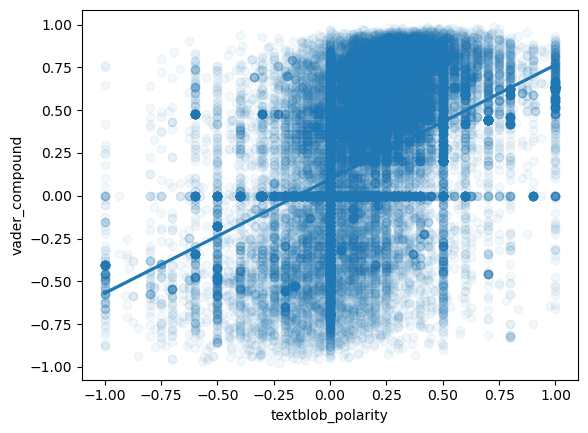

In [142]:
import seaborn as sns

sns.regplot(data = tweet_scores, x="textblob_polarity", y = "vader_compound", scatter_kws = {"alpha":0.05})

## Additional Resources

1. [Text and Data Mining Libguide](https://guides.lib.unc.edu/tdm)
2. 